## Titanic Machine Learning Exercise

The purpose of this exercise is to practice machine learning techniques in Python. The data and inspiration is from Kaggle's [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview).

"In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)."

The values in the second column ("Survived") can be used to determine whether each passenger survived or not:
* if it's a "1", the passenger survived.
* if it's a "0", the passenger died.

Variable Definition	Key: 

* survival	Survival	0 = No, 1 = Yes
* pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
* sex	Sex	
* Age	Age in years	
* sibsp	# of siblings / spouses aboard the Titanic	
* parch	# of parents / children aboard the Titanic	
* ticket	Ticket number	
* fare	Passenger fare	
* cabin	Cabin number	
* embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Other variable notes:
    
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Pushing notebook to GitHub: https://towardsdatascience.com/how-to-use-git-github-with-jupyter-notebook-7144d6577b44

> It is a simple binary classification problem, and all you need to do is predict if a particular passenger survived. The best thing about this dataset is that all the pre-processing is done for you. You have a nice, clean dataset to train your machine learning model.
**Since this is a classification problem, you can choose to use algorithms like logistic regression, decision trees, and random forests to build the predictive model. You can also choose gradient boosting models like an XGBoost classifier for this beginner-level machine learning project to get better results.**

From https://www.kdnuggets.com/2021/09/20-machine-learning-projects-hired.html

### Reading in the Data

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import poisson
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [329]:
# Read in the data to train the model
train=pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [330]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


The Name column is only valuable to us if we extract the title (Mr., Mrs., Miss to tell us if someone is married or unmarried). We can see that the title comes after the last name.

In [331]:
train['Name']=train["Name"].apply(lambda x: x.split(","))
train["Name"]=[x[1] for x in train["Name"]]
train['Name']=train["Name"].apply(lambda x: x.split())
train["title"]=[x[0] for x in train["Name"]]

In [332]:
train.title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the',
       'Jonkheer.'], dtype=object)

In [333]:
names=['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Rev.', 'Dr.']
train['title']=[x if x in names else "Unknown" for x in train["title"]]

In [334]:
train.title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Unknown', 'Rev.', 'Dr.'],
      dtype=object)

We can see that there are a few different title in our data set. I've created a new data column called "title".

In [335]:
# Overview of data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


By looking at these basic summary statistics and the first few rows of our data, we can see that we have 891 observations. 1 means the passenger survived, and 0 means that the passenger died. We can see that the average age of our passengers was around 30 years old.

Let's do a brief exploratory data analysis before we fit our machine learning models.

### Exploratory Data Analysis

In [336]:
print("Are there null values?", train.isnull().values.any())
print(train.isnull().sum())

Are there null values? True
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
title            0
dtype: int64


Here, we can see there are null values in Age, Cabin, and Embarked. I am likely going to drop the Cabin column since so many of the values are missing. I need to fill in the missing values for age. I can either remove those rows, fill in the missing values with 0, or fill in the missing values with the mean/mean of the row. I also could consider alternative techniques. For now, I am going to fill in those missing values with the median.

In [337]:
train['Age'].fillna(train['Age'].median(), inplace=True)

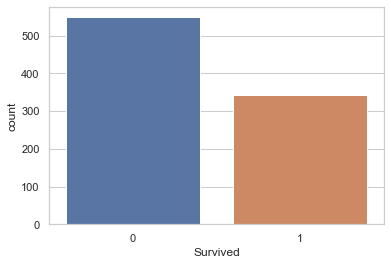

In [338]:
sns.countplot(data=train, x="Survived")
plt.show()

In [339]:
count_dead = len(train[train['Survived']==0])
count_survived = len(train[train['Survived']==1])
pct_dead = count_dead/len(train['Survived'])
print("percentage of dead is", pct_dead*100)
pct_survived = count_survived/len(train['Survived'])
print("percentage of survived", pct_survived*100)

percentage of dead is 61.61616161616161
percentage of survived 38.38383838383838


We can see that our data is imbalanced, as there are more people who died in the Titanic than survived.

In [340]:
train.groupby("Survived").mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.028233,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.291433,0.473684,0.464912,48.395408


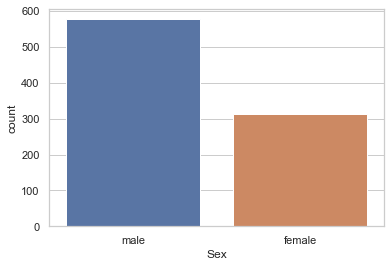

In [341]:
sns.countplot(data=train, x="Sex")
plt.show()

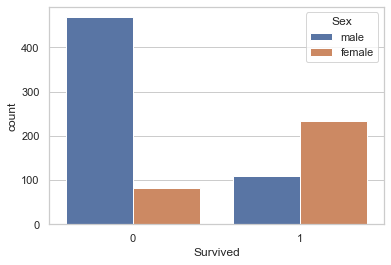

In [342]:
sns.countplot(data=train, x="Survived", hue="Sex")
plt.show()

We can see more woman survived than men.

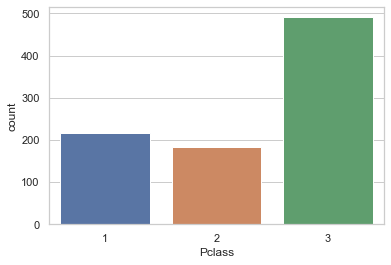

In [343]:
sns.countplot(data=train, x="Pclass")
plt.show()

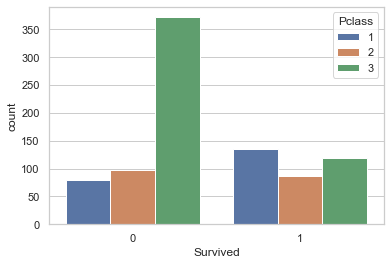

In [344]:
sns.countplot(data=train, x="Survived", hue="Pclass")
plt.show()

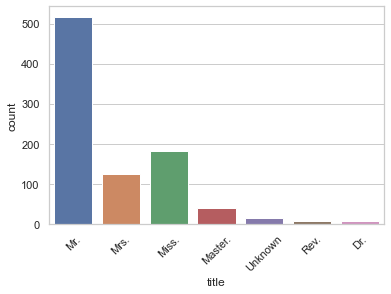

In [345]:
sns.countplot(data=train, x="title")
plt.xticks(rotation=45)
plt.show()

It looks like the 3rd class was more likely to die in the sinking of the pandemic.

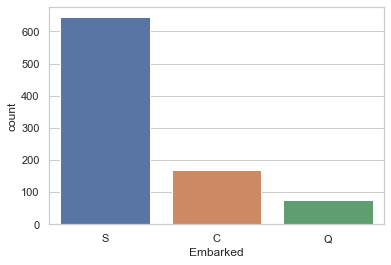

In [346]:
sns.countplot(data=train, x="Embarked")
plt.show()

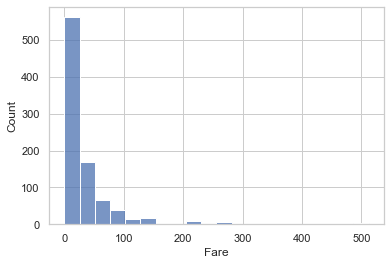

In [347]:
sns.histplot(data=train, x="Fare", bins=20)
plt.show()

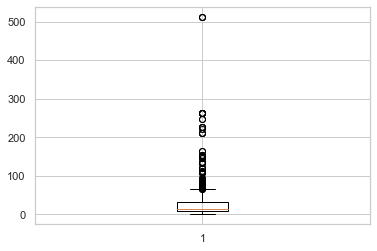

In [348]:
plt.boxplot(train['Fare'])
plt.show()

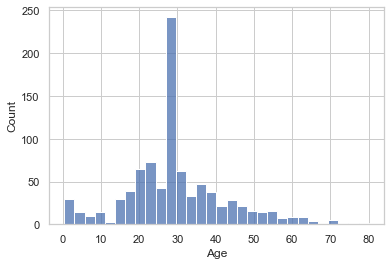

In [349]:
sns.histplot(data=train, x="Age")
plt.show()

In [350]:
mn=train.Age.min()
mx=train.Age.max()
x=np.linspace(mn,mx,100)
mean=train.Age.mean()
std=train.Age.std()
z=norm.pdf(x,mean,std)

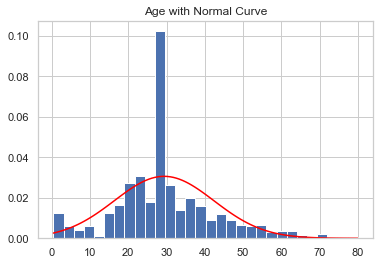

In [351]:
plt.hist(train['Age'], density=True, bins=30)
plt.plot(x,z,color="red")
plt.title("Age with Normal Curve")
plt.show()

What if we look at survival rate by age?

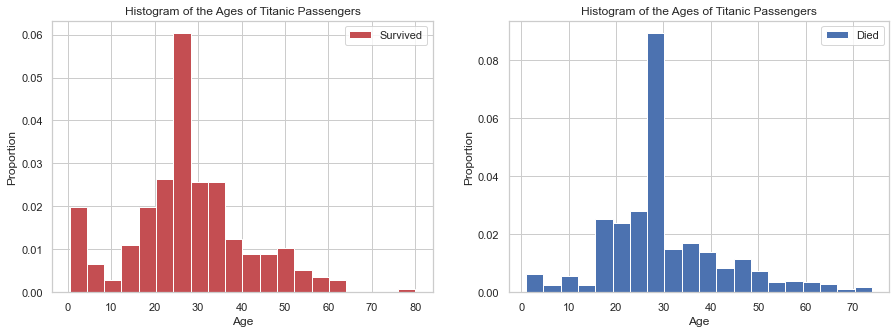

In [352]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

survived=train[train["Survived"]==1]
died=train[train["Survived"]==0]

ax[0].hist(survived['Age'], density=True, color='r', label='Survived', bins=20)
ax[1].hist(died['Age'], density=True, color='b', label='Died', bins=20)
ax[0].set(xlabel="Age", ylabel="Proportion", title="Histogram of the Ages of Titanic Passengers")
ax[1].set(xlabel="Age", ylabel="Proportion", title="Histogram of the Ages of Titanic Passengers")
ax[0].legend()
ax[1].legend()
plt.show()

We can see that the distributions are right skewed, especially for those who survived. Young people were more likely to survive the Titanic.

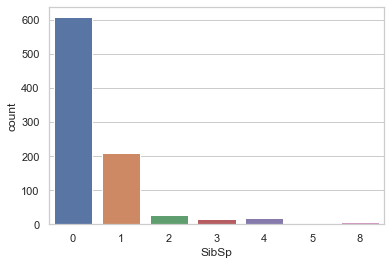

In [353]:
sns.countplot(data=train, x="SibSp")
plt.show()

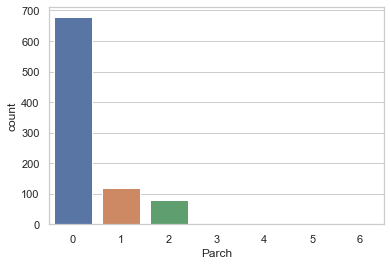

In [354]:
sns.countplot(data=train, x="Parch")
plt.show()

### Machine Learning Models

To begin, I am going to fit a logistic regression model. I am using code modified from [Towards Data Science](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8).

**Logistic Regression Assumptions**
* Binary logistic regression requires the dependent variable to be binary.
* For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
* Only the meaningful variables should be included.
* The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
* The independent variables are linearly related to the log odds.
* Logistic regression requires quite large sample sizes.

In [355]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"[Mr., Owen, Harris]",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"[Mrs., John, Bradley, (Florence, Briggs, Thayer)]",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"[Miss., Laina]",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"[Mrs., Jacques, Heath, (Lily, May, Peel)]",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"[Mr., William, Henry]",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


In [356]:
cat_vars=['Pclass','Sex','Embarked', "title"]
for var in cat_vars:
    cat_list='var'+'_'+ var
    cat_list = pd.get_dummies(train[var], prefix=var)
    data1=train.join(cat_list)
    train=data1

data_vars=data1.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_final=data1[to_keep]
data_final.columns.values

array(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'title_Dr.', 'title_Master.', 'title_Miss.', 'title_Mr.',
       'title_Mrs.', 'title_Rev.', 'title_Unknown'], dtype=object)

The Towards Data Science wants us to try a SMOTE algorithm (Synthetic Minority Oversampling Technique).

* Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

**We are going to use this to balance our data since there are more people who died than survived in our training set.**

In [357]:
# Drop unnecessary columns
data_final=data_final.drop(["PassengerId", "Name", "Ticket", "Cabin"],axis=1)
# We could extract the first letter from each Cabin name, but I am dropping the column for now

In [358]:
# SMOTE to balance data
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
X = data_final.loc[:, data_final.columns != 'Survived']
y = data_final.loc[:, data_final.columns == 'Survived']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Survived'])

# we can check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of people who died in oversampled data",len(os_data_y[os_data_y['Survived']==0]))
print("Number of survivors",len(os_data_y[os_data_y['Survived']==1]))
print("Proportion of died data in oversampled data is ",
      len(os_data_y[os_data_y['Survived']==0])/len(os_data_X))
print("Proportion of survived data in oversampled data is ",
      len(os_data_y[os_data_y['Survived']==1])/len(os_data_X))

Length of oversampled data is  762
Number of people who died in oversampled data 381
Number of survivors 381
Proportion of died data in oversampled data is  0.5
Proportion of survived data in oversampled data is  0.5


Our data set is now balanced! From Towards Data Science: *Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.*

**Recursive Feature Elimination**

> Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [359]:
data_final_vars=data_final.columns.values.tolist()
y=['Survived']
X=[i for i in data_final_vars if i not in y]

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/Users/elizabethtrahadias/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/elizabethtrahadias/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Information on transforming the data to remove the warning**: https://scikit-learn.org/stable/modules/preprocessing.html

In [360]:
X=os_data_X
y=os_data_y

In [361]:
# Implementing the model
import statsmodels.api as sm

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.444187
         Iterations: 35
                              Results: Logit
Model:                 Logit               Pseudo R-squared:    0.359     
Dependent Variable:    Survived            AIC:                 714.9408  
Date:                  2021-12-20 19:52    BIC:                 803.0237  
No. Observations:      762                 Log-Likelihood:      -338.47   
Df Model:              18                  LL-Null:             -528.18   
Df Residuals:          743                 LLR p-value:         1.7731e-69
Converged:             0.0000              Scale:               1.0000    
No. Iterations:        35.0000                                            
--------------------------------------------------------------------------
               Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
--------------------------------------------------------------------------
Age             0.0051      0.0084  0.5982 0.5497      -0.0115  

/Users/elizabethtrahadias/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The code cell below looks for patterns in four different columns ("Pclass", "Sex", "SibSp", and "Parch") of the data. It constructs the trees in the random forest model based on patterns in the train.csv file, before generating predictions for the passengers in test.csv. The code also saves these new predictions in a CSV file submission.csv.

In [362]:
# From https://www.kaggle.com/alexisbcook/titanic-tutorial
"""
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)
"""
#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)
#print("Your submission was successfully saved!")

'\nfrom sklearn.ensemble import RandomForestClassifier\n\ny = train_data["Survived"]\n\nfeatures = ["Pclass", "Sex", "SibSp", "Parch"]\nX = pd.get_dummies(train_data[features])\nX_test = pd.get_dummies(test_data[features])\n\nmodel = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)\nmodel.fit(X, y)\npredictions = model.predict(X_test)\n'